Автор:     Шестаков Михаил Сергеевич  
Telegram:  https://t.me/mshestakov1    
email:     mikhail-shestakov-2022@bk.ru  

# Прогнозирование риска возникновения ДТП

**Содержание:**  
1. [Подключение к базе и загрузка таблицы данных](#connect)    
 1.1. [Загрузка таблиц](#load_table)  
 1.2. [Первичное исследование таблиц](#first_analisys)  
    
    
2. [Cтатистический анализ факторов ДТП](#statistic)  
 2.1. [Распределение аварий по месяцам](#accident_month)  
 2.2. [Дополнительные задачи](#tasks)  
 
 
3. [Создание модели для оценки водительского риска](#statistic)  
 3.1. [Подготовка набора данных](#sample_preparation)  
 3.2. [Предобработка данных](#data_preparation)  
 3.3. [Подготовка модели](#model_preparation)  
 
 
4. [Подбор лучшей модели](#choose_model)  

5. [Проверка лучшей модели](#model_control)  

6. [Общий вывод](#final)  

**Заказчик исследования:** каршеринговая компания.  
**Цель исследования:** создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения.
**Особенности исследования:**


**Исходные данные:**  
Исходные данные представлены в четырех датесетах;

1. case_ids - данные по идентификатору события.  


2. collisions (информация о происшествиях):  
 - case_id (уникальный номер для зарегистрированного происшествия);
 - county_city_location (номер географического района, где произошло ДТП);
 - county_location (название географического района, где произошло ДТП);
 - distance (расстояние от главной дороги (метры));
 - direction (направление движения);
 - intersection (является ли место происшествие перекрёстком);
 - weather_1 (погода);
 - location_type (тип дороги); 
 - collision_damage (серьёзность происшествия);
 - party_count (количество участников); 
 - primary_coll_factor (основной фактор аварии);
 - pcf_violation_category (категория нарушения);
 - type_of_collision (тип аварии);
 - motor_vehicle_involved_with (дополнительные участники ДТП);
 - road_surface (состояние дороги);
 - road_condition_1 (дорожное состояние);
 - lighting (освещение);
 - control_condition_1 (устройство управления);
 - collision_date (дата происшествия);
 - collision_time (время происшествия).
 
3. parties (описание участников происшествия): 
 - case_id (уникальный номер для зарегистрированного происшествия);
 - party_number (номер участника происшествия);
 - party_type (тип участника происшествия);
 - at_fault (виновность участника);  
 - insurance_premium (сумма страховки);
 - party_sobriety (трезвость участника);
 - party_drug_physical (состояние участника: физическое или с учётом принятых лекарств);
 - cellphone_in_use (Наличие телефона в автомобиле (возможности разговаривать по громкой связи)).  
 
4. vehicles (Описание автомобиля):
 - case_id (уникальный номер для зарегистрированного происшествия);
 - party_number (номер участника происшествия);
 - vehicle_type (тип кузова);
 - vehicle_transmission (тип КПП);
 - vehicle_age (возраст автомобиля (в годах)).
 
**Идея решения задачи от заказчика:**  
1. Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
 - Для модели выбрать тип виновника — только машина (car).
 - Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
 - Для моделирования ограничиться данными за 2012 год — они самые свежие.
 - Обязательное условие — учесть фактор возраста автомобиля.
2. На основе модели исследовать основные факторы ДТП.
3. Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
 - Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
 - Какие ещё факторы нужно учесть?
 - Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?  
 

**Схема базы данных:**
 
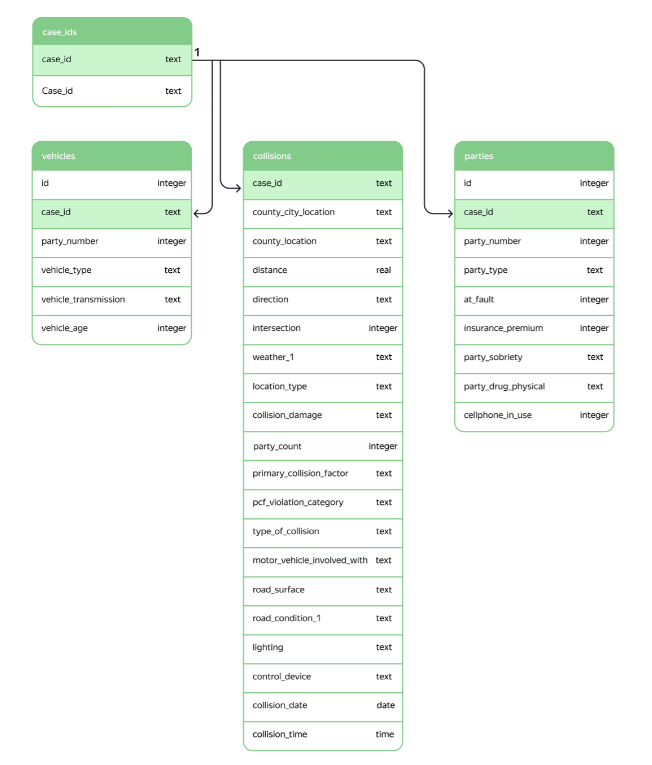

**Импорт библиотек**

In [2]:
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import timeit
import warnings

from catboost import CatBoostClassifier
from optuna.distributions import IntDistribution as intd
from optuna.distributions import UniformDistribution as unid
from optuna.distributions import LogUniformDistribution as log_unid
from optuna.distributions import CategoricalDistribution as catd
from optuna.distributions import FloatDistribution as floatd
from optuna.integration import OptunaSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sqlalchemy import create_engine 

warnings.filterwarnings("ignore")

## Подключение к базе и загрузка таблицы данных
<a id="connect"></a>

### Загрузка таблиц
<a id="load_table"></a>

Подключаемся к базе данных:

In [3]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

#сторока подключения к базе данных
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string) 

**Таблица parties**

In [4]:
sql_query = """
SELECT *
  FROM parties
"""
parties = pd.read_sql_query(sql_query, con=engine)

**Таблица collisions**

In [5]:
sql_query = """
SELECT *
  FROM collisions
"""
collisions = pd.read_sql_query(sql_query, con=engine)

**Таблица vehicles**

In [6]:
sql_query = """
SELECT *
  FROM vehicles
"""
vehicles = pd.read_sql_query(sql_query, con=engine)

**Таблица case_ids**

In [7]:
sql_query = """
SELECT *
  FROM case_ids
"""
case_ids = pd.read_sql_query(sql_query, con=engine)

## Первичное исследование таблиц
<a id="first_analisys"></a>

In [8]:
def inf(df):
    '''функция получения общей информации'''
    print('Размер датафрейма:')
    print(df.shape)
    print('_' * 50)
    print()
    print('Общая информация о датафрейме:')
    print(df.info(memory_usage='deep'))
    print('_' * 50)
    print()
    print('Несколько строк датафрейма:')
    display(df.sample(random_state=0, n=5))
    print('_' * 50)
    print()
    print('Количество полных дубликатов:')
    print(df.duplicated().sum())
    print('_' * 50)  
    try:
        if ('id' in df.columns) & ('case_id' in df.columns):
            print()
            print('Количество дубликатов без учета полей идентификаторов:')
            print(df.drop(columns=['id', 'case_id']).duplicated().sum())
            print('_' * 50)
        elif 'id' in df.columns:
            print()
            print('Количество дубликатов без учета полей идентификаторов:')
            print(df.drop(columns=['id']).duplicated().sum())
            print('_' * 50)
        elif 'case_id' in df.columns:
            print()
            print('Количество дубликатов без учета полей идентификаторов:')
            print(df.drop(columns=['case_id']).duplicated().sum())
            print('_' * 50)
    except:
        pass           
    print()
    print('Описательная статистика строковых значений:')
    display(df.describe(include=['object']).T)
    print('_' * 50)
    print()
    print('Описательная статистика числовых значений:')
    display(df.describe().T)
    print('_' * 50)
    print()
    print('Количество пропусков:')
    print(df.isna().sum())
    print()
    print('Количество пропусков в процентах:')
    print(df.isna().mean()*100) 

**Таблица parties**

In [9]:
inf(parties)

Размер датафрейма:
(2752408, 9)
__________________________________________________

Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752408 entries, 0 to 2752407
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   case_id              object 
 2   party_number         int64  
 3   party_type           object 
 4   at_fault             int64  
 5   insurance_premium    float64
 6   party_sobriety       object 
 7   party_drug_physical  object 
 8   cellphone_in_use     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 713.0 MB
None
__________________________________________________

Несколько строк датафрейма:


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
1214743,660322,4461911,1,car,1,26.0,had not been drinking,None,0.0
1322379,782391,4535269,1,car,0,57.0,had not been drinking,None,0.0
2314804,1911501,5184605,2,car,0,53.0,had not been drinking,None,0.0
1457914,936553,4627666,2,car,0,35.0,had not been drinking,None,0.0
1254438,705605,4486324,2,car,1,69.0,had not been drinking,None,0.0


__________________________________________________

Количество полных дубликатов:
0
__________________________________________________

Количество дубликатов без учета полей идентификаторов:
2731584
__________________________________________________

Описательная статистика строковых значений:


,count,unique,top,freq
case_id,2752408,1400000,5196744,27
party_type,2748786,5,car,2469314
party_sobriety,2678453,6,had not been drinking,2124727
party_drug_physical,432288,5,G,232901


__________________________________________________

Описательная статистика числовых значений:


,count,mean,std,min,25%,50%,75%,max
id,2752408.0,1.376204e+06,794551.894197,1.0,688102.75,1376204.5,2064306.25,2752408.0
party_number,2752408.0,1.598029e+00,0.723657,1.0,1.00,1.0,2.00,27.0
at_fault,2752408.0,4.680000e-01,0.498975,0.0,0.00,0.0,1.00,1.0
insurance_premium,2347006.0,3.874724e+01,16.378511,0.0,25.00,36.0,50.00,105.0
cellphone_in_use,2240771.0,2.045055e-02,0.141536,0.0,0.00,0.0,0.00,1.0


__________________________________________________

Количество пропусков:
id                           0
case_id                      0
party_number                 0
party_type                3622
at_fault                     0
insurance_premium       405402
party_sobriety           73955
party_drug_physical    2320120
cellphone_in_use        511637
dtype: int64

Количество пропусков в процентах:
id                      0.000000
case_id                 0.000000
party_number            0.000000
party_type              0.131594
at_fault                0.000000
insurance_premium      14.728994
party_sobriety          2.686920
party_drug_physical    84.294189
cellphone_in_use       18.588705
dtype: float64


**Таблица collisions**

In [10]:
inf(collisions)

Размер датафрейма:
(1400000, 20)
__________________________________________________

Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   case_id                      1400000 non-null  object 
 1   county_city_location         1400000 non-null  object 
 2   county_location              1400000 non-null  object 
 3   distance                     1400000 non-null  float64
 4   direction                    1059358 non-null  object 
 5   intersection                 1387781 non-null  float64
 6   weather_1                    1392741 non-null  object 
 7   location_type                518779 non-null   object 
 8   collision_damage             1400000 non-null  object 
 9   party_count                  1400000 non-null  int64  
 10  primary_collision_factor     1391834 non-null 

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
192509,4824050,1941,los angeles,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,wrong side of road,broadside,bicycle,dry,None,daylight,none,2010-07-17,19:41:00
1092874,5475121,4203,santa barbara,40.0,east,0.0,clear,None,small damage,3,vehicle code violation,dui,rear end,parked motor vehicle,dry,normal,dark with street lights,none,2011-10-09,02:57:00
668609,4585569,3612,san bernardino,30.0,east,0.0,clear,None,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2010-01-12,17:40:00
890126,5062798,1941,los angeles,45.0,east,0.0,clear,highway,small damage,2,unknown,unknown,sideswipe,other motor vehicle,dry,normal,daylight,functioning,2011-01-10,13:45:00
605765,4455180,4311,santa clara,300.0,west,0.0,clear,None,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,dry,normal,dark with no street lights,none,2009-11-02,18:10:00


__________________________________________________

Количество полных дубликатов:
0
__________________________________________________

Количество дубликатов без учета полей идентификаторов:
158
__________________________________________________

Описательная статистика строковых значений:


,count,unique,top,freq
case_id,1400000,1400000,5561209,1
county_city_location,1400000,538,1942,170335
county_location,1400000,58,los angeles,433809
direction,1059358,4,south,290513
weather_1,1392741,7,clear,1121048
location_type,518779,3,highway,416531
collision_damage,1400000,5,small damage,845771
primary_collision_factor,1391834,5,vehicle code violation,1316453
pcf_violation_category,1372046,23,speeding,438439
type_of_collision,1388176,7,rear end,467109


__________________________________________________

Описательная статистика числовых значений:


,count,mean,std,min,25%,50%,75%,max
distance,1400000.0,660.711516,11785.785065,0.0,2.0,100.0,430.0,8363520.0
intersection,1387781.0,0.224909,0.417522,0.0,0.0,0.0,0.0,1.0
party_count,1400000.0,1.966006,0.672446,1.0,2.0,2.0,2.0,27.0


__________________________________________________

Количество пропусков:
case_id                             0
county_city_location                0
county_location                     0
distance                            0
direction                      340642
intersection                    12219
weather_1                        7259
location_type                  881221
collision_damage                    0
party_count                         0
primary_collision_factor         8166
pcf_violation_category          27954
type_of_collision               11824
motor_vehicle_involved_with      6819
road_surface                    13093
road_condition_1                11988
lighting                         8593
control_device                   8407
collision_date                      0
collision_time                  12308
dtype: int64

Количество пропусков в процентах:
case_id                         0.000000
county_city_location            0.000000
county_location                 0.00

**Таблица vehicles**

In [11]:
inf(vehicles)

Размер датафрейма:
(1021234, 6)
__________________________________________________

Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  object 
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  object 
 4   vehicle_transmission  997575 non-null   object 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 205.9 MB
None
__________________________________________________

Несколько строк датафрейма:


,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
335174,323097,4418209,1,coupe,manual,6.0
986873,924993,5064272,3,sedan,manual,8.0
413703,1040828,5179371,1,sedan,auto,9.0
75996,159166,4250721,2,coupe,auto,4.0
619612,850716,4980903,2,coupe,manual,6.0


__________________________________________________

Количество полных дубликатов:
0
__________________________________________________

Количество дубликатов без учета полей идентификаторов:
1019972
__________________________________________________

Описательная статистика строковых значений:


,count,unique,top,freq
case_id,1021234,792642,5196744,27
vehicle_type,1021234,5,sedan,488665
vehicle_transmission,997575,2,auto,502243


__________________________________________________

Описательная статистика числовых значений:


,count,mean,std,min,25%,50%,75%,max
id,1021234.0,760162.799710,438619.364211,1.0,380694.25,761762.5,1141347.75,1517654.0
party_number,1021234.0,1.609510,0.679095,1.0,1.00,2.0,2.00,27.0
vehicle_age,996652.0,5.137088,3.110310,0.0,3.00,5.0,7.00,161.0


__________________________________________________

Количество пропусков:
id                          0
case_id                     0
party_number                0
vehicle_type                0
vehicle_transmission    23659
vehicle_age             24582
dtype: int64

Количество пропусков в процентах:
id                      0.000000
case_id                 0.000000
party_number            0.000000
vehicle_type            0.000000
vehicle_transmission    2.316707
vehicle_age             2.407088
dtype: float64


**Таблица case_ids**

In [12]:
inf(case_ids)

Размер датафрейма:
(1400000, 2)
__________________________________________________

Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   case_id  1400000 non-null  object
 1   db_year  1400000 non-null  object
dtypes: object(2)
memory usage: 166.9 MB
None
__________________________________________________

Несколько строк датафрейма:


,case_id,db_year
192509,4297412,2021
1092874,5312737,2021
668609,4853738,2021
890126,5096572,2021
605765,4779061,2021


__________________________________________________

Количество полных дубликатов:
0
__________________________________________________

Количество дубликатов без учета полей идентификаторов:
1399999
__________________________________________________

Описательная статистика строковых значений:


,count,unique,top,freq
case_id,1400000,1400000,5191467,1
db_year,1400000,1,2021,1400000


__________________________________________________

Описательная статистика числовых значений:


,count,unique,top,freq
case_id,1400000,1400000,5191467,1
db_year,1400000,1,2021,1400000


__________________________________________________

Количество пропусков:
case_id    0
db_year    0
dtype: int64

Количество пропусков в процентах:
case_id    0.0
db_year    0.0
dtype: float64


**Вывод:**  
В таблицах приведены данные по ДТП, по ним невозможно предсказать возможно ли избежать инцидента, так как данные по таковым исходам отсутствуют. Если до предоставленным данным предсказывать вероятность ДТП, то она составит 100%. Поскольку целевым признаком выбран at_fault (виновность участника), то результатом прогнозирования будет определение виновника ДТП. Это может быть полезно для контроля над финансовыми издержками, возникающими вследствие ДТП, но не для решения сформулированной в условиях задачи.  

1. таблица parties (описание участников происшествия):
 - в таблице 2752408 строк и 9 признаков. Признаки соответствуют указанным в условии;
 - полные дубликаты отсутствуют.
2. таблица collisions (информация о происшествиях):
 - в таблице 1400000 строк и 20 признаков. Признаки соответствуют указанным в условии;
 - полные дубликаты отсутствуют;
 - приведённый в условиях признак  control_condition_1 по факту имеет наименование control_device;
 - приведённый в условиях признак  primary_coll_factor по факту имеет наименование primary_collision_factor;
 - при импорте данных типы данных признаков collision_date и collision_time изменены с date и time на object.
3. таблица vehicles (Описание автомобиля):
 - в таблице 1021234 строк и 6 признаков. Признаки соответствуют указанным в условии;
 - полные дубликаты отсутствуют.
4. таблица case_ids:
 - в таблице 1400000 строк и 2 признаков. Признаки соответствуют указанным в условии;
 - полные дубликаты отсутствуют.
 
Таблицы связаны общим признаком case_id (уникальный номер для зарегистрированного происшествия).  
Таблицы vehicles и parties связаны признаком party_number (номер участника происшествия).

## Cтатистический анализ факторов ДТП
<a id="statistic"></a>

### Распределение аварий по месяцам
<a id="accident_month"></a>

Загружаем таблицу, содержащую данные о количествах происшествий по каждому месяцу за весь период наблюдений:

In [13]:
sql_query = """
SELECT DATE_TRUNC('MONTH', collision_date) AS month,
       COUNT(DISTINCT case_id) AS accidents
  FROM collisions
 GROUP BY DATE_TRUNC('MONTH', collision_date)
"""
accident_month_all = pd.read_sql_query(sql_query, con=engine)

Визуализируем распределение:

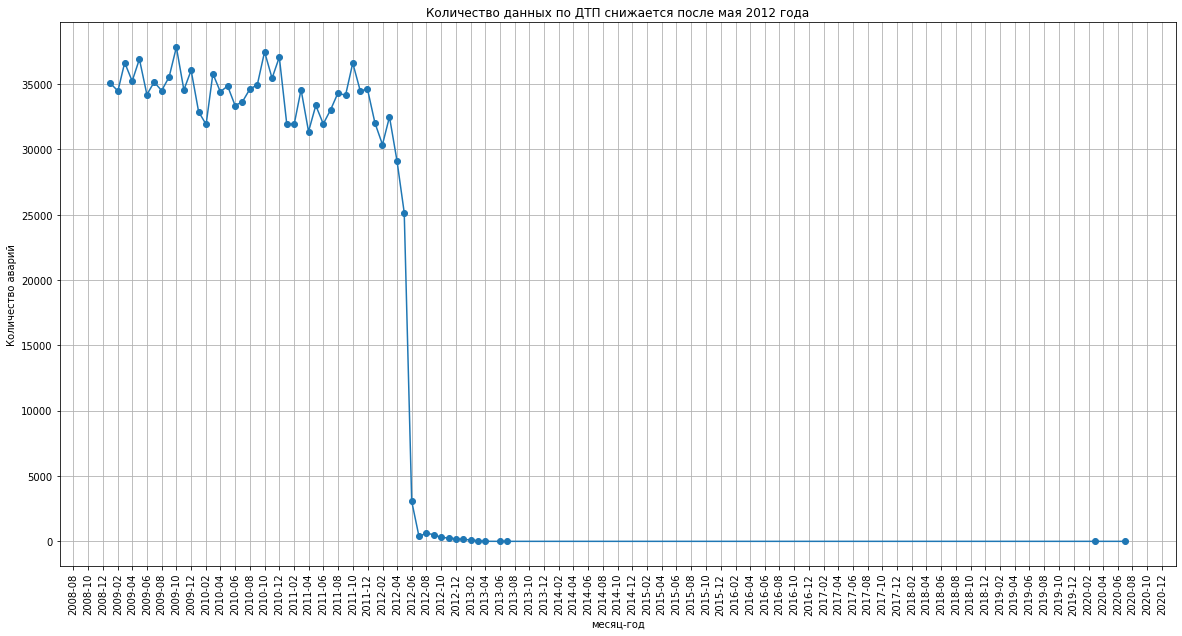

In [14]:
plt.figure(figsize=(20,10))
plt.plot(accident_month_all['month'], accident_month_all['accidents'], 'o-')
plt.title('Количество данных по ДТП снижается после мая 2012 года')
plt.xlabel('месяц-год')
plt.ylabel('Количество аварий')
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.grid()
plt.show()

В таблицах содержатся данные по ДТП за период с января 2009 года по август 2020 года. Данных по событиям, произошедших после мая 2012 года, значительно меньше, нежели тех, что произошли до этой даты. Во избежания искажения результатов анализа исключаем их из рассмотрения.

Загружаем таблицу, содержащую данные о количествах происшествий по месяцам за период с июня 2009 по май 2012, чтобы собрать информацию по каждому месяцу за три года:

In [15]:
sql_query = """
SELECT CAST(EXTRACT(MONTH FROM collision_date) as INT) AS month,
       COUNT(DISTINCT case_id) AS accidents
  FROM collisions
 WHERE collision_date BETWEEN '2009-06-01' AND '2012-05-01'
 GROUP BY CAST(EXTRACT(MONTH FROM collision_date) as INT)
"""
accident_month = pd.read_sql_query(sql_query, con=engine)
accident_month

,month,accidents
0,1,96838
1,2,94270
2,3,102886
3,4,94936
4,5,69173
5,6,99531
6,7,101835
7,8,103467
8,9,104649
9,10,111933


Визуализируем распределение:

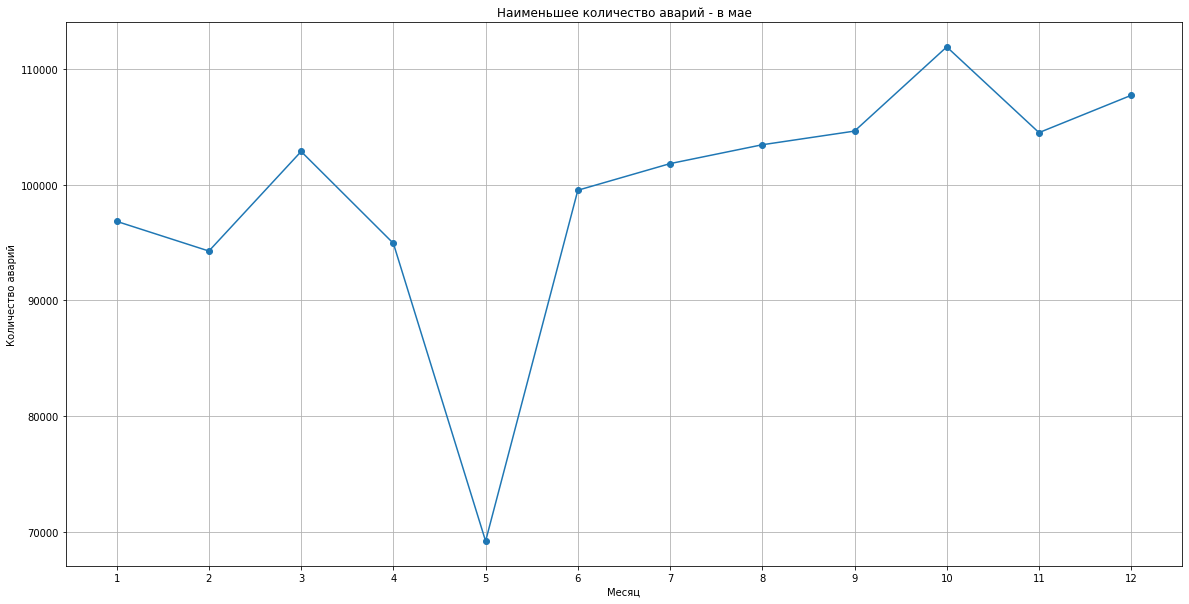

In [16]:
plt.figure(figsize=(20,10))
plt.plot(accident_month['month'], accident_month['accidents'], 'o-')
plt.title('Наименьшее количество аварий - в мае')
plt.xlabel('Месяц')
plt.ylabel('Количество аварий')
plt.locator_params (axis='x', nbins= 13)
plt.grid()
plt.show()

Наименьшее количество аварий - в мае: 69173. Наибольшее количество аварий - осень: от 104517 в ноябре до 111933 в октябре.

### Дополнительные задачи
<a id="tasks"></a>

**Задачи для проработки**  
1. Определить среднюю сумму страховки в зависимости возраста автомобиля (таблицы parties и vehicles).  
2. Определить количество нетрезвых виновников ДТП по дням недели (таблицы collisions и parties).  
3. Серьёзность происшествия в зависимости от освещения (таблица collisions).  
4. Определить количество участников ДТП в зависимости от погодных условий (таблица collisions).  
5. Определить дорожное состояние в зависимости удаленности от главной дороги (таблица collisions).  
6. Определить дорожное состояние в зависимости удаленности от географического района (таблица collisions). 

**Пример решения задачи 1**

В данных присутствует автомобиль возрастом 161 год. Маловероятно, что каршеринговая компания предоставляет столь раритетный автомобиль, тем более что первая модель бензинового автотранспорта появилась только в 1870 году. Убираем из рассмотрения автомобили возрастом более 50 лет.

In [17]:
sql_query = """
SELECT v.vehicle_age,
       AVG(p.insurance_premium) AS mean_insurance_premium
  FROM vehicles AS v
 INNER JOIN parties AS p ON v.case_id=p.case_id  AND v.party_number = p.party_number
 INNER JOIN collisions AS c ON v.case_id = c.case_id
 WHERE c.collision_date BETWEEN '2009-06-01' AND '2012-05-01'
       AND v.vehicle_age < 50
 GROUP BY v.vehicle_age
 ORDER BY v.vehicle_age
"""
insurance_age = pd.read_sql_query(sql_query, con=engine)

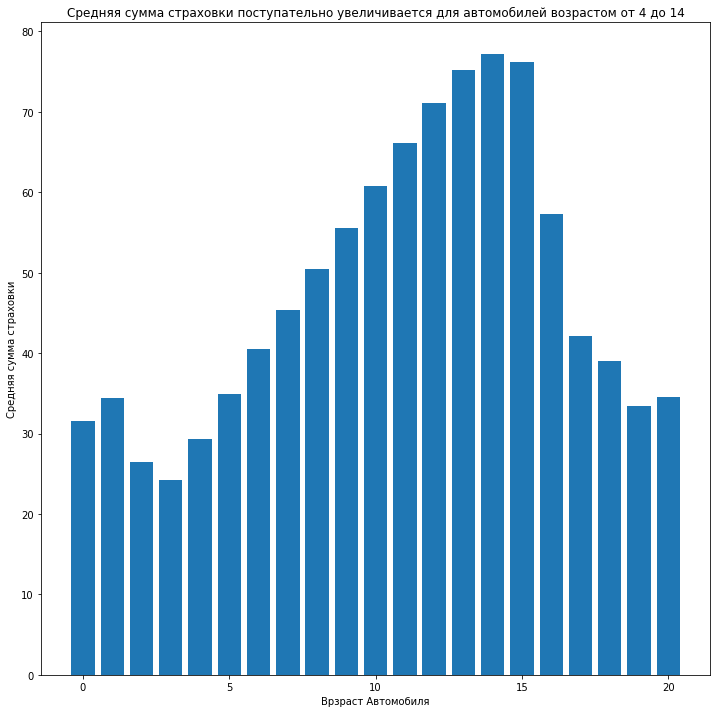

In [18]:
plt.figure(figsize=(12,12))
ax = plt.bar(insurance_age['vehicle_age'], insurance_age['mean_insurance_premium'])
plt.title('Средняя сумма страховки поступательно увеличивается для автомобилей возрастом от 4 до 14')
plt.ylabel('Средняя сумма страховки')
plt.xlabel('Врзраст Автомобиля')
plt.show()

Для автомобилей возрастом 0-4 года средняя сумма страховки колеблется в диапазоне 25-30 тысяч долларов.  
Для автомобилей возрастом 4-14 лет средняя сумма страховки поступательно увеличивается до 78 тысяч долларов.  
Для автомобилей возрастом свыше 14 лет средняя сумма страховки уменьшается: вероятно, возникают проблемы со страхованием столь старых автомобилей. Вероятно, часть автомобилей эксплуатируются без страховки.

**Пример решения задачи 2**

In [19]:
sql_query = """
SELECT c.collision_date,
       p.party_sobriety
  FROM collisions AS c
 INNER JOIN parties AS p ON c.case_id=p.case_id
 WHERE c.collision_date BETWEEN '2009-06-01' AND '2012-05-01'
       AND p.at_fault = 1
       AND p.party_sobriety IN ('had been drinking, not under influence', 'had been drinking, under influence', 'had been drinking, impairment unknown')
"""
sobriety_day = pd.read_sql_query(sql_query, con=engine)

In [20]:
sobriety_day['weekday'] = pd.to_datetime(sobriety_day['collision_date'], errors='coerce').dt.dayofweek

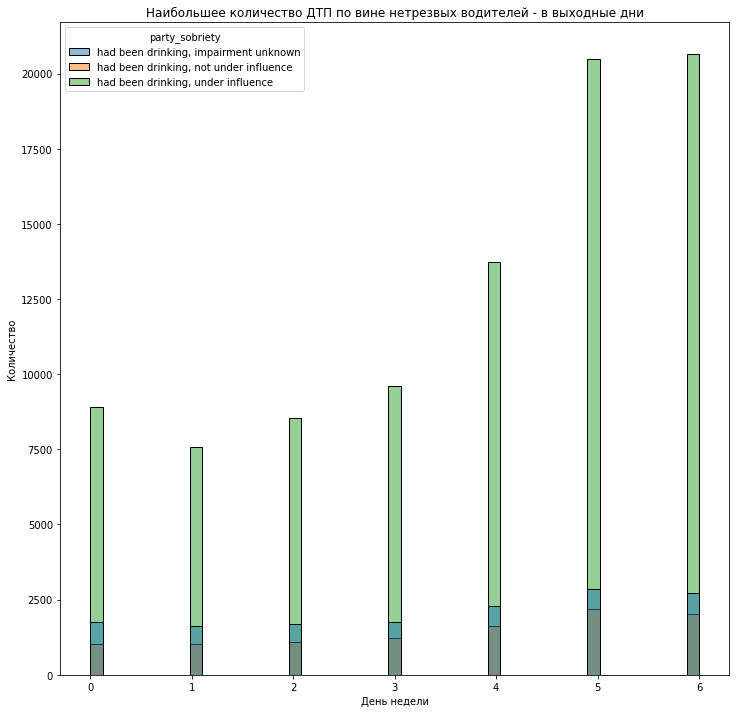

In [21]:
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.histplot(data=sobriety_day, x='weekday', hue= 'party_sobriety')
plt.title('Наибольшее количество ДТП по вине нетрезвых водителей - в выходные дни')
plt.ylabel('Количество')
plt.xlabel('День недели')
plt.show()

Количество ДТП по вине нетрезвых водителей - в будние дни, с понедельника по четверг. С пятницы количество ДТП по вине нетрезвых водителей возрастает и достигает пика в выходные дни.

**Вывод:**  
В таблицах содержатся данные по ДТП за период с января 2009 года по август 2020 года. Данных по событиям, произошедших после мая 2012 года, значительно меньше, нежели тех, что произошли до этой даты.  
Анализ выполнен на данных за период с июня 2009 по май 2012.  
Наименьшее количество аварий - в мае: 69173. Наибольшее количество аварий - осень: от 104517 в ноябре до 111933 в октябре.  

Для подготовки к совещанию предложено проработать следующие задачи:
1. Определить среднюю сумму страховки в зависимости возраста автомобиля (таблицы parties и vehicles).  
2. Определить количество нетрезвых виновников ДТП по дням недели (таблицы collisions и parties).  
3. Серьёзность происшествия в зависимости от освещения (таблица collisions).  
4. Определить количество участников ДТП в зависимости от погодных условий (таблица collisions).  
5. Определить дорожное состояние в зависимости удаленности от главной дороги (таблица collisions).  
6. Определить дорожное состояние в зависимости удаленности от географического района (таблица collisions).  

Приведены примеры решения первых двух задач. По ним можно сделать следующие выводы:  
1. Для автомобилей возрастом 0-4 года средняя сумма страховки колеблется в диапазоне 25-30 тысяч долларов.  
   Для автомобилей возрастом 4-14 лет средняя сумма страховки поступательно увеличивается до 78 тысяч долларов.  
   Для автомобилей возрастом свыше 14 лет средняя сумма страховки уменьшается: вероятно, возникают проблемы со страхованием столь старых автомобилей. Вероятно, часть автомобилей эксплуатируются без страховки.  
2. Количество ДТП по вине нетрезвых водителей - в будние дни, с понедельника по четверг. С пятницы количество ДТП по вине нетрезвых водителей возрастает и достигает пика в выходные дни.  

## Создание модели для оценки водительского риска
<a id="make_model"></a>

### Подготовка набора данных
<a id="sample_preparation"></a>

Для решения задачи прогнозирования отбираем условия (признаки), способные повлиять на риск возникновения ДТП, значения которых можно определить до начала поездки.  
Признаки, выбранные для решения поставленной задачи:  

- county_location - в различных регионах могут отличаться правила дорожного движения, уровни развития дорожной инфраструктуры и т.д.;
- distance - отдаленность от главной дороги ограничивает доступ к службам технического обслуживания автомобиля, возможен недостаточный уровень развития дорожной инфраструктуры;
- direction - в зависимости от региона некоторые дороги могут иметь сложные участки. Если клиент выбирает маршрут в направлении этих улиц, есть вероятность, что он на них свернет;
- intersection - перекресток - место повышенного риска ДТП;
- weather_1 - плохие погодные условия - фактор риска;
- location_type - на различных типах дорог различные условия движения: скоростной режим, регулирование движение и т.д.;
- road_surface - дорожное покрытие может быть мокрым, заснеженным и т.д.;
- road_condition_1 - низкое качество дорожного покрытия - фактор риска;
- lighting - дороги могут быть недостаточно освещены, особенности на большом удалении от главной дороги;
- control_device - нефункционирующее устройство контроля - фактор риска;
- collision_date - в количестве ДТП может присутствовать сезонность;  
- collision_time - в количестве ДТП может присутствовать сезонность;  
- vehicle_type - от типа кузова может зависеть, едет ли клиент один или с семьей, а значит и уровень его ответственности;  
- vehicle_transmission - использование механической коробки передач требует специального навыка и достаточного опыта;  
- vehicle_age - возможная поломка автомобиля - фактор риска;  
- party_sobriety - алкогольное опьянение - фактор риска.  

Также добавлен целевой признак at_fault.

Загружаем вышеперечисленные признаки с учетом требований заказчика:
 - тип виновника — только машина (car);
 - ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина);
 - данные только за 2012 год.

In [22]:
sql_query = '''
SELECT c.county_location,
       c.distance,
       c.direction,
       c.intersection,
       c.weather_1,
       c.location_type,
       c.road_surface,
       c.road_condition_1, 
       c.lighting,
       c.control_device,
       c.collision_date,
       c.collision_time,
       v.vehicle_type,
       v.vehicle_transmission,
       v.vehicle_age,
       p.party_sobriety,
       p.at_fault
  FROM case_ids AS ci
 INNER JOIN vehicles AS v ON ci.case_id = v.case_id
 INNER JOIN collisions AS c ON ci.case_id = c.case_id
 INNER JOIN parties AS p ON ci.case_id = p.case_id AND p.party_number = v.party_number
 WHERE p.party_type = 'car' AND c.collision_damage != 'scratch' AND EXTRACT(YEAR FROM c.collision_date) = 2012;
'''
df_all = pd.read_sql_query(sql_query, con=engine)

### Предобработка данных
<a id="data_preparation"></a>

Переводим значения признака "collision_date" в формат даты:

In [23]:
df_all['collision_date'] = pd.to_datetime(df_all['collision_date'], errors='coerce')

Определяем месяц и день события:

In [24]:
df_all['month'] = df_all['collision_date'].dt.month_name()
df_all['weekday'] = df_all['collision_date'].dt.day_name()

Определяем час, в который произошло события:

In [25]:
df_all['collision_hour'] = pd.to_datetime(df_all['collision_time'], format='%H:%M:%S').dt.hour.astype('float64')

Удаляем из рассмотрения исходные признаки "collision_date" и "collision_time":

In [26]:
df_all = df_all.drop(['collision_date', 'collision_time'], axis=1)

Пропуски признаков "intersection" и "vehicle_age" заменяем на наиболее часто встречающиеся значения соответствующих признаков:

In [27]:
for i in ['intersection', 'vehicle_age']:
    df_all.loc[df_all[i].isna(), i] = df_all[i].value_counts().argmax()

Пропуски признака "collision_hour" заменяем на наиболее часто встречающиеся значение по дням недели:

In [28]:
for i in df_all['weekday'].unique():
    df_all.loc[(df_all['collision_hour'].isna()) & (df_all['weekday'] == i), 'collision_hour'] =\
    df_all.loc[(df_all['collision_hour'].notna()) & (df_all['weekday'] == i)].value_counts().argmax()

Пропуски текстовых признаков заменяем на "not stated":

In [29]:
for i in df_all.columns:
    if df_all[i].dtypes == 'O':
        df_all.loc[df_all[i].isna(), i] = 'not stated'
        df_all[i] = df_all.apply(lambda x: x[i].lower(), axis = 1)

Меняем классификацию уровня алкогольного опьянения: водитель либо нетрезв, либо трезв, либо состояние не определено:

In [30]:
df_all.loc[df_all['party_sobriety'].str.contains('had been drinking'), 'party_sobriety'] = 'had been drinking'
df_all.loc[(df_all['party_sobriety'] == 'not applicable'), 'party_sobriety'] = 'impairment unknown'

**Обработка аномальных значений**

Проверяем числовые значения на выбросы:

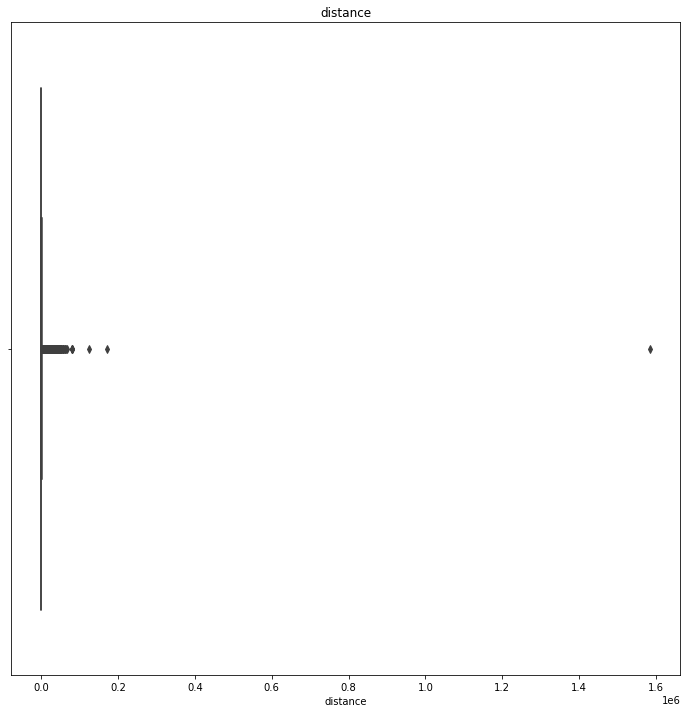

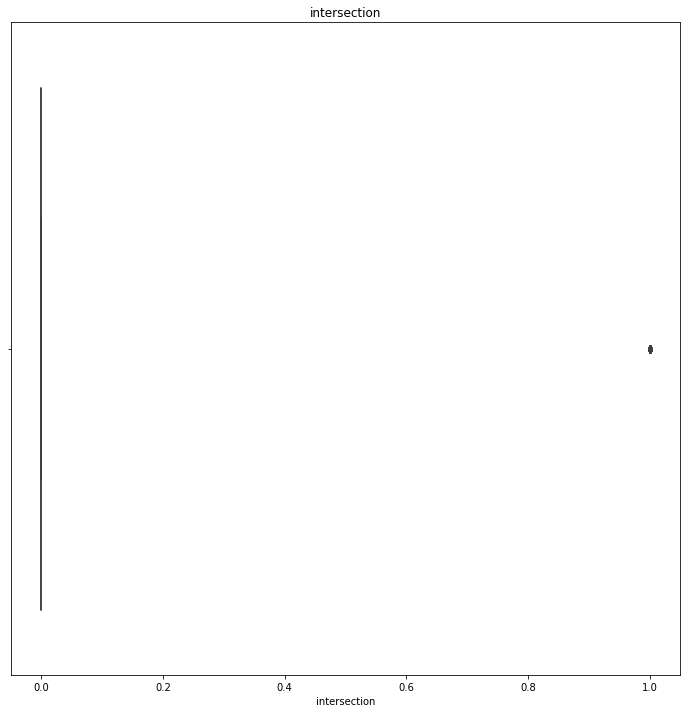

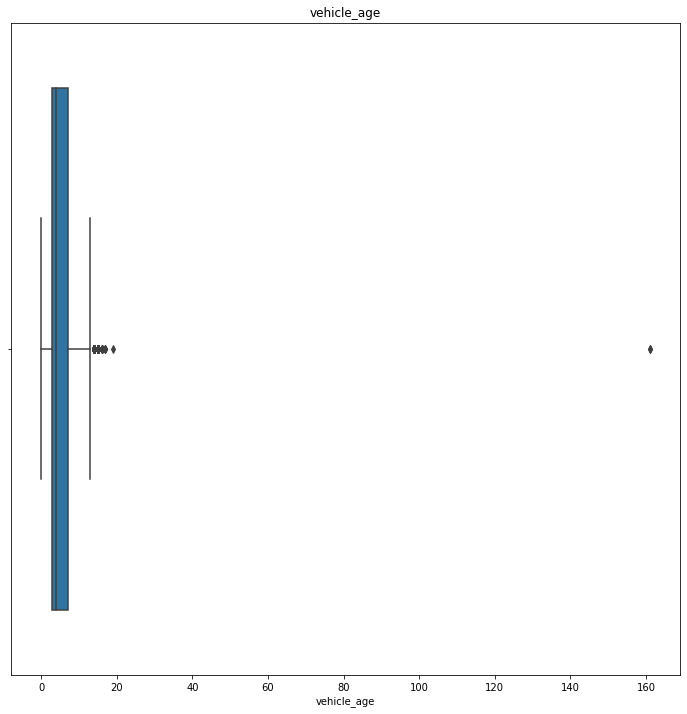

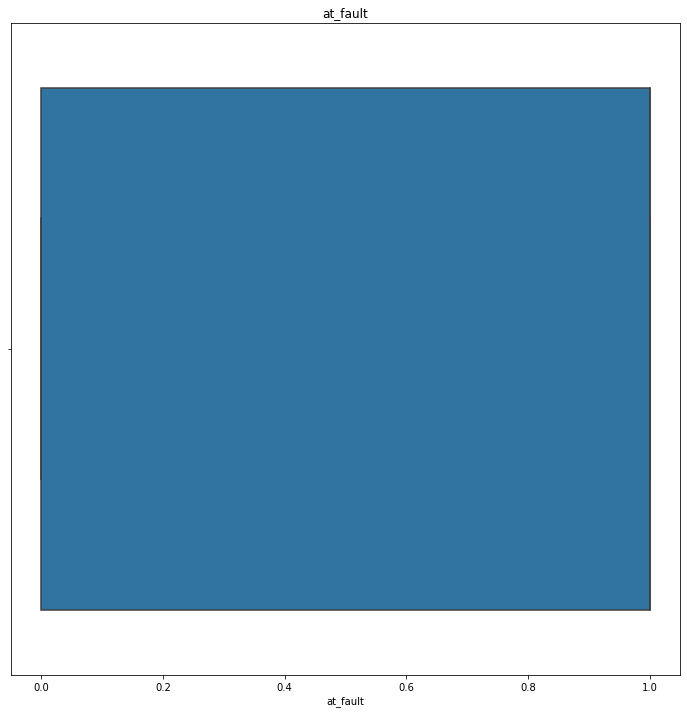

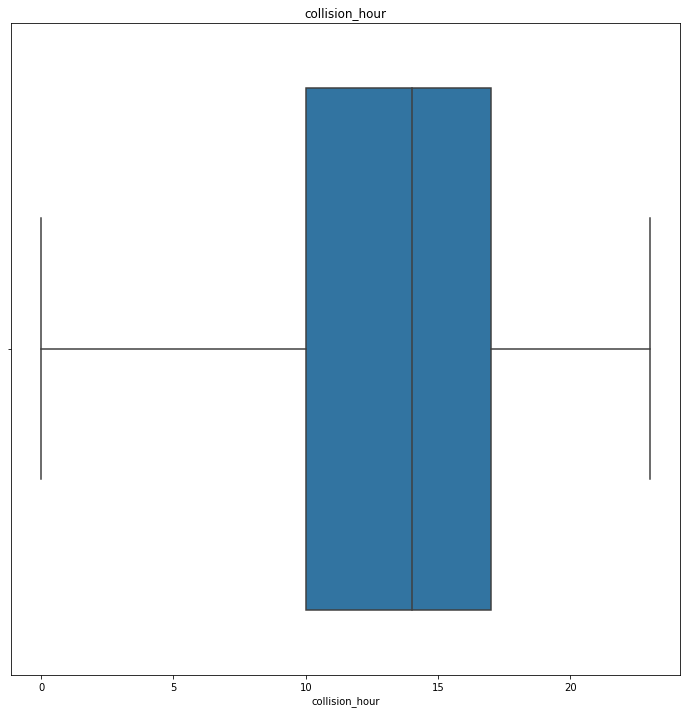

In [31]:
for i in df_all.columns:
    if df_all[i].dtypes != 'O':
        ax = plt.figure(figsize=(12,12))
        sns.boxplot(x=i, data=df_all)
        plt.title(i)
        plt.show()

Присутствуют аномальные значения признаков distance и vehicle_age. Удаляем выбросы:

In [32]:
df_all = df_all.query('distance < 500000 & vehicle_age < 50')

In [33]:
for i in df_all.columns:
    if df_all[i].dtypes == 'O':
        print('{}:'.format(i))
        print()
        for j in df_all[i].sort_values().unique():
            print(j)
        print()
        print('_' * 50)
        print()

county_location:

alameda
alpine
amador
butte
calaveras
colusa
contra costa
del norte
el dorado
fresno
glenn
humboldt
imperial
inyo
kern
kings
lake
lassen
los angeles
madera
marin
mariposa
mendocino
merced
modoc
mono
monterey
napa
nevada
orange
placer
plumas
riverside
sacramento
san benito
san bernardino
san diego
san francisco
san joaquin
san luis obispo
san mateo
santa barbara
santa clara
santa cruz
shasta
sierra
siskiyou
solano
sonoma
stanislaus
sutter
tehama
trinity
tulare
tuolumne
ventura
yolo
yuba

__________________________________________________

direction:

east
north
not stated
south
west

__________________________________________________

weather_1:

clear
cloudy
fog
not stated
other
raining
snowing
wind

__________________________________________________

location_type:

highway
intersection
not stated
ramp

__________________________________________________

road_surface:

dry
not stated
slippery
snowy
wet

__________________________________________________

road_conditi

Текстовые значения корректны, неявные дубликаты отсутствуют.

**Корреляция признаков**

Во избежание негативного влияния выбросов и нелинейности взаимосвязей признаков для расчёта корреляции применяем коэффициент Спирмена.  
Строим тепловую карту признаков для обучающей выборки:

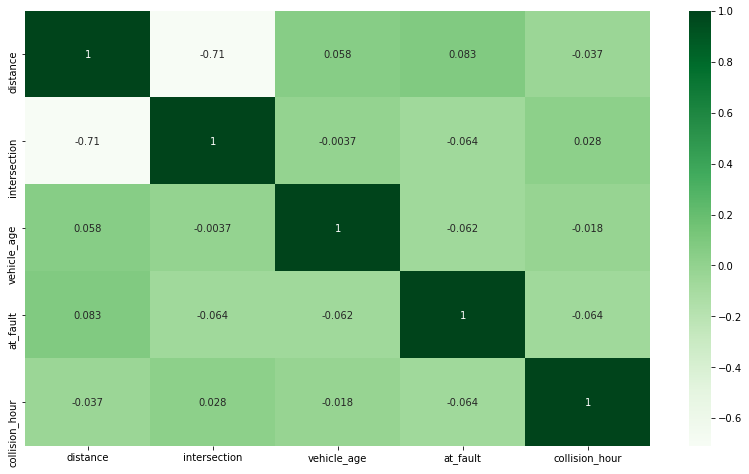

In [34]:
plt.figure(figsize=(14,8))
sns.heatmap(df_all.corr(method = 'spearman'), cmap="Greens", annot=True)
plt.show()

Корреляция (обратная) наблюдается только у признаков distance и intersection: -0.71.

### Подготовка модели
<a id="model_preparation"></a>

Проверяем на дисбаланс классов:

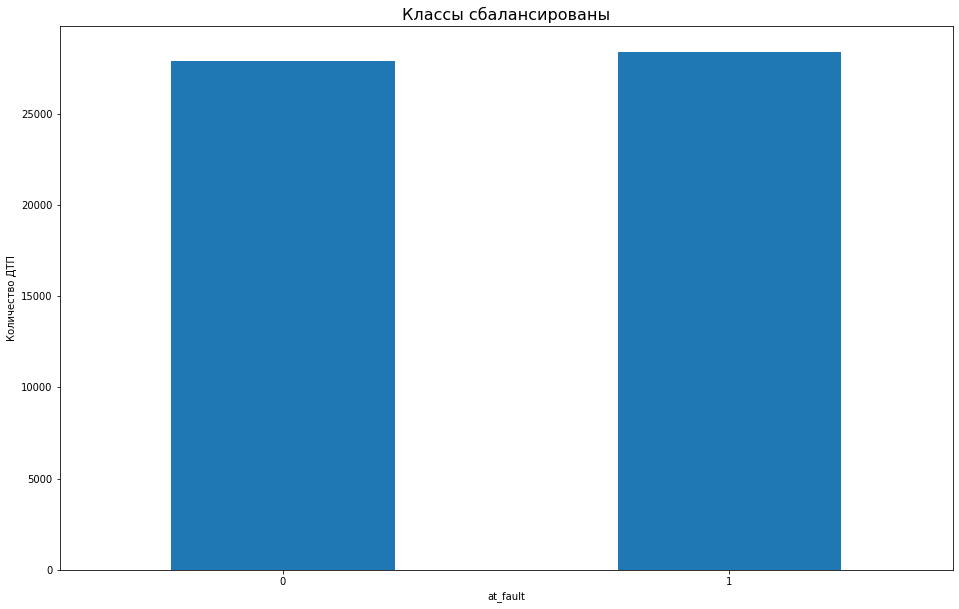

In [35]:
df_all_size = df_all.groupby('at_fault')['county_location'].count()
fig = plt.figure(figsize=(16,10))
ax = df_all_size.plot.bar()
plt.title('Классы сбалансированы', fontsize=16)
plt.ylabel('Количество ДТП')
plt.xticks(rotation=0)
plt.show()

Классы сбалансированы.

Задаем значение параметра random_state:

In [36]:
RAND_STATE = 5

Разделяем признаки на категориальные и количественные:

In [37]:
categorical_features = ['county_location', 'direction', 'weather_1', 'location_type', 'control_device', 'party_sobriety',
                        'road_surface', 'road_condition_1', 'lighting', 'vehicle_type', 'vehicle_transmission', 'month', 'weekday']
numerical_features = ['distance', 'intersection', 'vehicle_age', 'collision_hour']

Выделяем из выборки целевой признак:

In [38]:
X = df_all.drop(['at_fault'], axis=1)
y = df_all['at_fault']

Разделяем выборку на обучающую и тестовую:

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True, random_state=RAND_STATE)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

Будут обучаться модели LogisticRegression, RandomForestClassifier, DecisionTreeClassifier и Catboost. Для моделей LogisticRegression, RandomForestClassifier, DecisionTreeClassifier необходимо масштабирование количественных признаков и категоризация категориальных. Кодировать категориальные значения будем методом OneHotEncoder (OHE).

In [40]:
class ScalerTransformation(BaseEstimator, TransformerMixin):
    '''класс обучения и трансформации для масштабирования количественных признаков'''
    scaler = StandardScaler()
    
    def fit(self, X, y=None):
        X = X.copy()                                               # делаем копию матрицы признаков
        self.scaler.fit(X[numerical_features])                           # обучаем scaler на числовых данных обучающей выборки
        return self
    
    def transform(self, X):
        X = X.copy()                                               # делаем копию матрицы признаков
        X[numerical_features] = self.scaler.transform(X[numerical_features])   # масштабируем числовые значения
        return X

In [41]:
class OheTransform(BaseEstimator, TransformerMixin): 
    '''класс обучения и трансформации для кодирования категориальных признаков'''
    
    encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
    
    def fit(self, X, y=None):
        X = X.copy()                              # делаем копию матрицы признаков
        self.encoder.fit(X[categorical_features])         # обучаем encoder на категориальных данных обучающей выборки
        return self
    
    def transform(self, X):
        X = X.copy()                                                         # делаем копию матрицы признаков
        feature_arr = self.encoder.transform(X[categorical_features]).toarray()      # кодируем категориальные значения
        ohe_labels = self.encoder.get_feature_names_out(categorical_features)        # создаем список названий новых признаков
        features = pd.DataFrame(                                             # собираем результаты в датафрейм
               feature_arr,
               columns=ohe_labels)
        X = X.join(features)                                                 # добавляем результаты кодирования в исходную таблицу
        X = X.drop(categorical_features, axis=1)                                     # удаляем исходные категориальные столбцы
        X.columns = map(str.lower, X.columns)                                # переводим названия столбцов в нижний регистр
        
        return X

Создаем пайплайн и обучаем его на обучающей выборке:

In [42]:
pipe = make_pipeline(ScalerTransformation(), OheTransform())                        # создаем пайплайн
pipe.fit(X_train)                                                                   # обучаем пайплайн

Pipeline(steps=[('scalertransformation', ScalerTransformation()),
                ('ohetransform', OheTransform())])

Трансформируем обучающую и тестовую выборки:

In [43]:
X_train_transf = pipe.transform(X_train)                                    # трансформируем обучающую выборку
X_test_transf = pipe.transform(X_test)                                      # трансформируем тестовую выборку

**Вывод:**
1. Загруженные следующие признаки:
 - county_location;
 - distance;
 - direction;
 - intersection;
 - weather_1;
 - location_type;
 - motor_vehicle_involved_with;
 - road_surface;
 - road_condition_1;
 - lighting;
 - control_device;
 - collision_date;  
 - collision_time;  
 - vehicle_type;  
 - vehicle_transmission;  
 - vehicle_age;
 - party_sobriety;
 - at_fault.

2. В отдельные признаки выделены месяц, день и час события.  
3. Пропуски признаков intersection и vehicle_age заменены на наиболее часто встречающиеся значения.  
4. Пропуски признака "collision_hour" заменены на наиболее часто встречающиеся значение по дням недели.  
5. Пропуски текстовых признаков заменены на "not stated".  
6. Удалены события с аномальными значениями признаков distance и vehicle_age.
7. Корреляция (обратная) наблюдается только у признаков distance и intersection: -0.71.
8. Классы сбалансированы.  
9. Данные подготовлены для обучения моделей.

## Подбор лучшей модели
<a id="choose_model"></a>

In [44]:
def auc_roc_diagr(model, X_test):
    '''функция отрисовки ROC-кривой'''
    
    probabilities_test = model.predict_proba(X_test)
    probabilities_one_test = probabilities_test[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, label='Лучшая модель')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Наивная модель')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend()
    plt.show()

In [45]:
def metrics(model, params, X_train=X_train_transf, X_test=X_test_transf, n_trial=10):
    '''функция обучения моделей и расчёта метрик'''
    
    model = OptunaSearchCV(model, params, scoring='recall', cv=3, n_trials=n_trial)    # передаем данные в OptunaSearchCV
    start_time = timeit.default_timer()                                                # начальное время обучения
    model.fit(X_train, y_train)                                                        # обучаем модель
    time_fit = timeit.default_timer() - start_time                                     # длительность обучения
    start_time = timeit.default_timer()                                                # начальное время предсказания
    pred = model.predict(X_test)                                                       # делаем предсказание
    time_pred = timeit.default_timer() - start_time                                    # длительность предсказания
    recall = model.best_score_                                                         # метрика recall
    auc_roc = roc_auc_score(y_test, pred).round(3)                                     # метрика auc_roc
    f1 = f1_score(y_test, pred).round(3)                                               # метрика f1
    
    print('Recall: {:.5f}'.format(recall))                                             # выводим метрику recall
    print('Auc_roc: {}'.format(auc_roc))                                               # выводим метрику auc_roc
    print('F1: {}'.format(f1))                                                         # выводим метрику f1
    
    auc_roc_diagr(model.best_estimator_, X_test)                                       # вызываем функцию отрисовки roc_curve
    
    return model, recall, auc_roc, f1, pred, time_fit, time_pred

Для решения поставленной задачи модель должна эффективно определять положительный класс: нужно выявить максимальное количество потенциальных виновников ДТП. При этом не имеет значения, будут ли ошибки в отношении клиентов, не представляющих угрозу. В связи с этим для оценки качества модели выбираем метрику Recall.

**LogisticRegression**

In [46]:
params_lr = {'C': intd(1, 10, False, 3)}                                     # значения гиперпараметров модели для подбора
model_lr = LogisticRegression(max_iter=1000, random_state=RAND_STATE)        # создаем модель

[I 2023-07-26 04:09:57,874] A new study created in memory with name: no-name-d70d99b5-913e-4c21-8e63-dfee4f28fa67
[I 2023-07-26 04:10:34,064] Trial 0 finished with value: 0.518656049363219 and parameters: {'C': 4}. Best is trial 0 with value: 0.518656049363219.
[I 2023-07-26 04:11:09,557] Trial 1 finished with value: 0.518656049363219 and parameters: {'C': 4}. Best is trial 0 with value: 0.518656049363219.
[I 2023-07-26 04:11:50,064] Trial 2 finished with value: 0.518656049363219 and parameters: {'C': 7}. Best is trial 0 with value: 0.518656049363219.
[I 2023-07-26 04:12:25,664] Trial 3 finished with value: 0.518656049363219 and parameters: {'C': 4}. Best is trial 0 with value: 0.518656049363219.
[I 2023-07-26 04:13:05,556] Trial 4 finished with value: 0.518656064577743 and parameters: {'C': 10}. Best is trial 4 with value: 0.518656064577743.
[I 2023-07-26 04:13:42,164] Trial 5 finished with value: 0.518656049363219 and parameters: {'C': 4}. Best is trial 4 with value: 0.51865606457774

Recall: 0.51896
Auc_roc: 0.636
F1: 0.588


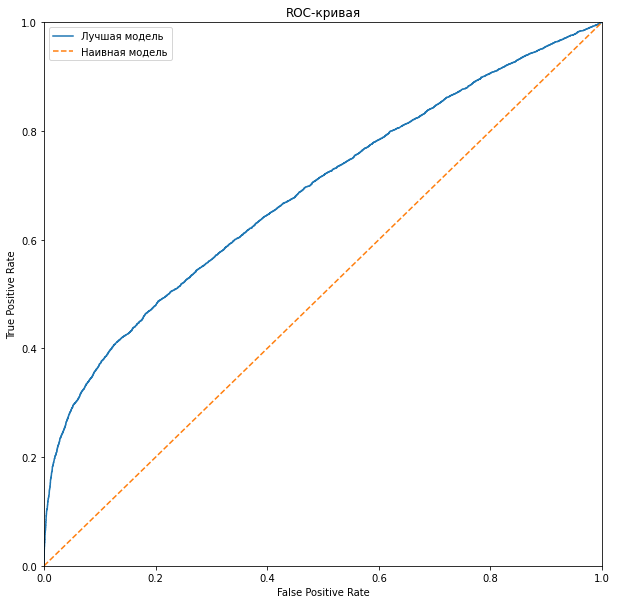

In [47]:
best_model_lr, recall_lr, auc_roc_lr, f1_lr, pred_lr, time_fit_lr, time_pred_lr = metrics(model_lr, params_lr)

**RandomForestClassifier**

In [48]:
params_rfc = {'min_samples_leaf' : intd(1, 10, False, 1),                     # значения гиперпараметров модели для подбора
                      'min_samples_split' : intd(2, 10, False, 1),
                      'max_depth' : intd(1, 10, False, 1),
                      'n_estimators' : intd(100, 150, False, 10)}
model_rfc = RandomForestClassifier(random_state=RAND_STATE)                   # создаем модель

[I 2023-07-26 04:16:10,239] A new study created in memory with name: no-name-dfd73ef4-ac51-4f16-8ced-16d9a6ac8d12
[I 2023-07-26 04:16:11,828] Trial 0 finished with value: 0.612618446971374 and parameters: {'min_samples_leaf': 9, 'min_samples_split': 4, 'max_depth': 1, 'n_estimators': 110}. Best is trial 0 with value: 0.612618446971374.
[I 2023-07-26 04:16:16,058] Trial 1 finished with value: 0.5018883430424818 and parameters: {'min_samples_leaf': 7, 'min_samples_split': 5, 'max_depth': 9, 'n_estimators': 100}. Best is trial 0 with value: 0.612618446971374.
[I 2023-07-26 04:16:20,403] Trial 2 finished with value: 0.5018883430424818 and parameters: {'min_samples_leaf': 7, 'min_samples_split': 5, 'max_depth': 9, 'n_estimators': 100}. Best is trial 0 with value: 0.612618446971374.
[I 2023-07-26 04:16:23,168] Trial 3 finished with value: 0.4984132468600646 and parameters: {'min_samples_leaf': 10, 'min_samples_split': 4, 'max_depth': 4, 'n_estimators': 110}. Best is trial 0 with value: 0.612

Recall: 0.61262
Auc_roc: 0.621
F1: 0.621


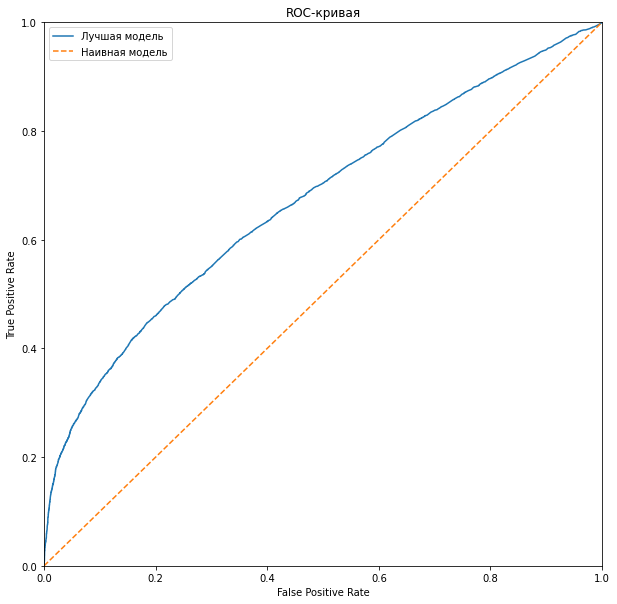

In [49]:
best_model_rfc, recall_rfc, auc_roc_rfc, f1_rfc, pred_rfc, time_fit_rfc, time_pred_rfc = metrics(model_rfc, params_rfc)

**DecisionTreeClassifier**

In [50]:
params_dtc = {'min_samples_leaf' : intd(1, 10, False, 1),                 # значения гиперпараметров модели для подбора
                      'min_samples_split' : intd(6, 10, False, 1),
                      'max_depth' : intd(6, 10, False, 1)}
model_dtc = DecisionTreeClassifier(random_state=RAND_STATE)               # создаем модель

[I 2023-07-26 04:16:47,545] A new study created in memory with name: no-name-2dbe37fa-2088-41b6-9aba-511484a61a89
[I 2023-07-26 04:16:48,148] Trial 0 finished with value: 0.5213741545098817 and parameters: {'min_samples_leaf': 9, 'min_samples_split': 10, 'max_depth': 10}. Best is trial 0 with value: 0.5213741545098817.
[I 2023-07-26 04:16:48,792] Trial 1 finished with value: 0.5173457365176115 and parameters: {'min_samples_leaf': 10, 'min_samples_split': 7, 'max_depth': 10}. Best is trial 0 with value: 0.5213741545098817.
[I 2023-07-26 04:16:49,268] Trial 2 finished with value: 0.5488193529354218 and parameters: {'min_samples_leaf': 1, 'min_samples_split': 10, 'max_depth': 7}. Best is trial 2 with value: 0.5488193529354218.
[I 2023-07-26 04:16:49,801] Trial 3 finished with value: 0.5045047619178029 and parameters: {'min_samples_leaf': 3, 'min_samples_split': 10, 'max_depth': 10}. Best is trial 2 with value: 0.5488193529354218.
[I 2023-07-26 04:16:50,335] Trial 4 finished with value: 0.

Recall: 0.60376
Auc_roc: 0.638
F1: 0.615


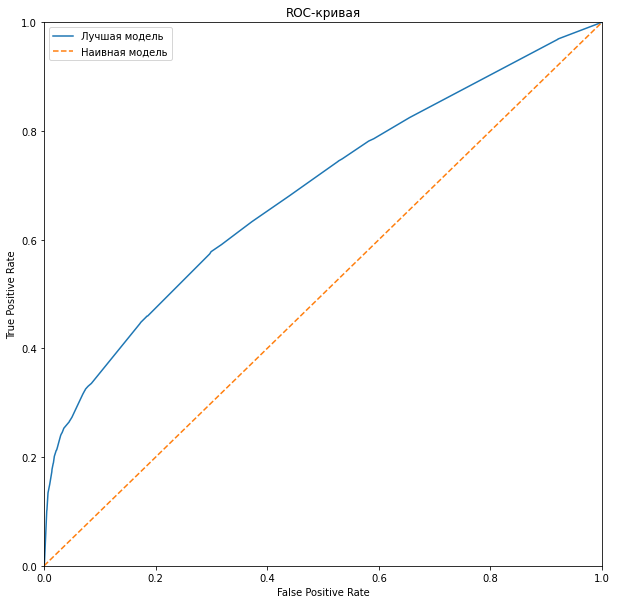

In [51]:
best_model_dtc, recall_dtc, auc_roc_dtc, f1_dtc, pred_dtc, time_fit_dtc, time_pred_dtc = metrics(model_dtc, params_dtc)

**Catboost**

In [52]:
params_cb = {                                                         # значения гиперпараметров модели для подбора
    'depth' : intd(8, 10, False, 2),
    'l2_leaf_reg': intd(2, 4, False, 2)
}

model_cb = CatBoostClassifier(verbose=False,                          # создаем модель
                           iterations = 1000,
                           cat_features = categorical_features,
                           learning_rate = 0.01,
                           eval_metric = "Recall")

[I 2023-07-26 04:16:53,127] A new study created in memory with name: no-name-3e7647b7-f525-40d1-a9e7-276d41687851
[I 2023-07-26 04:22:24,330] Trial 0 finished with value: 0.5301874642363594 and parameters: {'depth': 8, 'l2_leaf_reg': 4}. Best is trial 0 with value: 0.5301874642363594.
[I 2023-07-26 04:32:35,210] Trial 1 finished with value: 0.5347697974049195 and parameters: {'depth': 10, 'l2_leaf_reg': 4}. Best is trial 1 with value: 0.5347697974049195.
[I 2023-07-26 04:38:02,138] Trial 2 finished with value: 0.5295327756601697 and parameters: {'depth': 8, 'l2_leaf_reg': 2}. Best is trial 1 with value: 0.5347697974049195.


Recall: 0.53477
Auc_roc: 0.648
F1: 0.598


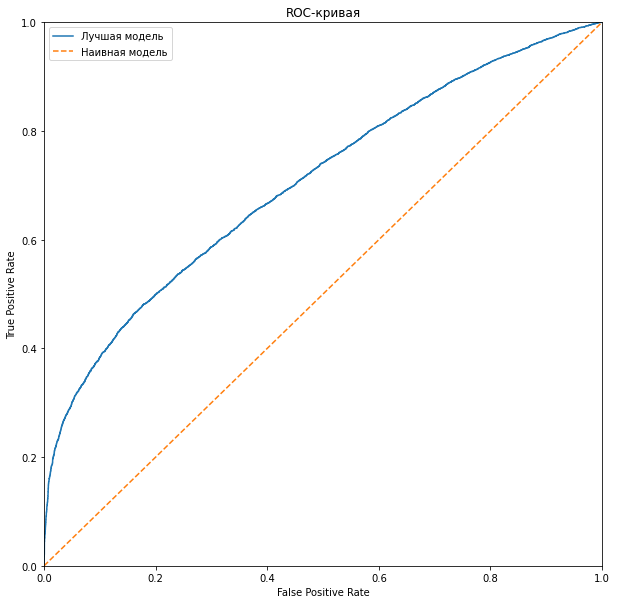

In [53]:
best_model_cb, recall_cb, auc_roc_cb, f1_cb, pred_cb, time_fit_cb, time_pred_cb = metrics(model_cb,
                                                                                          params_cb,
                                                                                          X_train,
                                                                                          X_test,
                                                                                          n_trial=3)

**Сравнительная таблица**

In [54]:
# собираем таблицу
df_best_model = pd.DataFrame({'model' : ['LogisticRegression', 'RandomForestClassifier', 'DecisionTreeClassifier', 'Catboost'],
                              'recall' : [recall_lr, recall_rfc, recall_dtc, recall_cb],
                              'f1' : [f1_lr, f1_rfc, f1_dtc, f1_cb],
                              'auc_roc' : [auc_roc_lr, auc_roc_rfc, auc_roc_dtc, auc_roc_cb],
                              'time_fit' : [time_fit_lr, time_fit_rfc, time_fit_dtc, time_fit_cb],
                              'time_pred' : [time_pred_lr, time_pred_rfc, time_pred_dtc, time_pred_cb],
                              'best_model' : [best_model_lr, best_model_rfc, best_model_dtc, best_model_cb],
                              'y_pred' : [pred_lr, pred_rfc, pred_dtc, pred_cb]})
df_best_model[['model', 'recall', 'f1', 'auc_roc', 'time_fit', 'time_pred']]                # выводим таблицу

,model,recall,f1,auc_roc,time_fit,time_pred
0,LogisticRegression,0.518958,0.588,0.636,371.795003,0.099120
1,RandomForestClassifier,0.612618,0.621,0.621,36.914706,0.089375
2,DecisionTreeClassifier,0.603757,0.615,0.638,5.307487,0.007901
3,Catboost,0.534770,0.598,0.648,1549.833379,0.470013


## Проверка лучшей модели
<a id="model_control"></a>

Выделяем из таблицы модель с наибольшим Recall:

In [55]:
best_model_row = df_best_model.loc[df_best_model['recall'] == df_best_model['recall'].max()]

**Матрица ошибок**

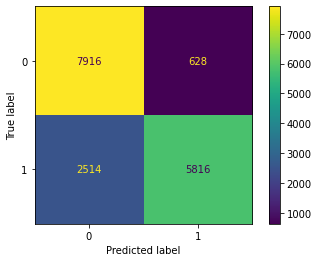

In [56]:
cm = confusion_matrix(best_model_row.iloc[0, 7], pred_lr)                       # рассчитываем матрицу ошибок
disp = ConfusionMatrixDisplay(confusion_matrix=cm)                              
disp.plot()                                                                     # визуализируем матрицу ошибок
plt.show()

**Важность основных факторов**

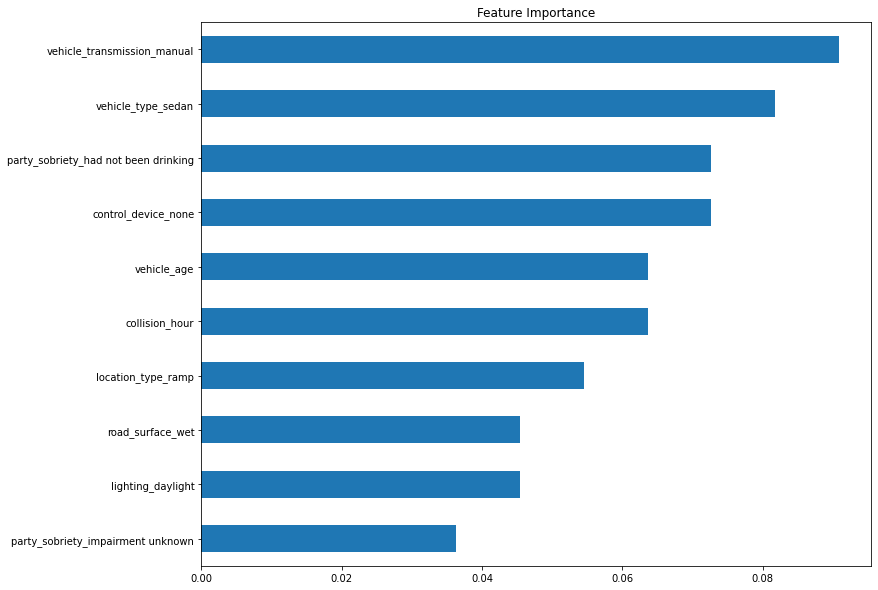

In [57]:
if best_model_row.iloc[0, 6] == 'LogisticRegression':
    importance = best_model_lr.best_estimator_.coef_[0]      # получаем коэффициенты признаков для модели LogisticRegression
else:
    # получаем коэффициенты признаков для других моделей
    importance = best_model_row.iloc[0, 6].best_estimator_.feature_importances_
# собираем признаки в серию
importance_features = pd.Series(importance, index=X_train_transf.columns).sort_values(ascending=True).tail(10)
plt.figure(figsize=(12,10))                                           # задаем размер окна диаграммы
importance_features.plot(kind='barh',title = 'Feature Importance')    # визуализируем диаграмму
plt.show()

Зависимость целевого признака от наиболее важного признака - тип коробки передач:

vehicle_transmission
manual        16080
auto          11872
not stated      419
Name: at_fault, dtype: int64

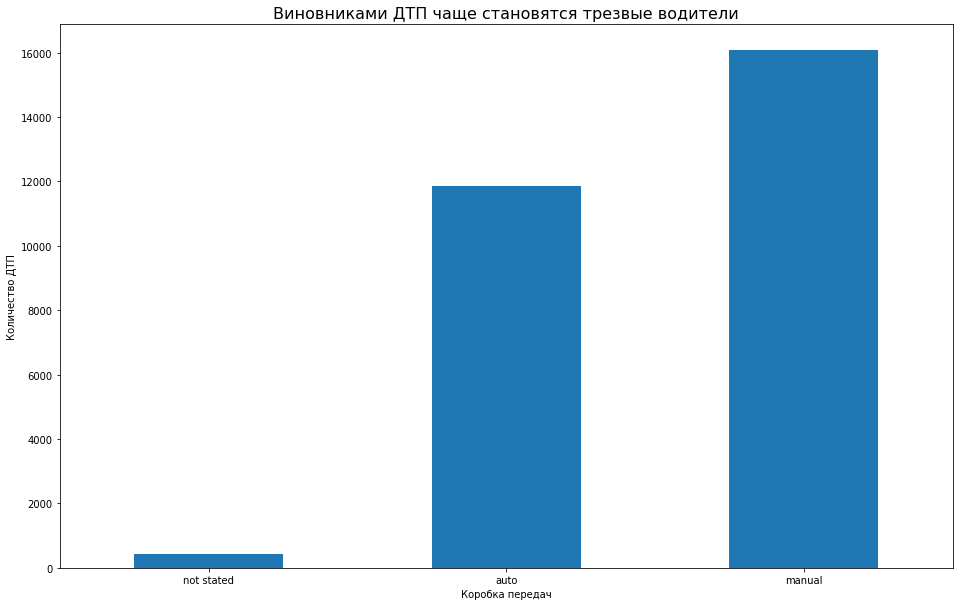

In [61]:
df_all_size = (                                                    # таблица зависимости at_fault от party_sobriety
    df_all
    .query('at_fault == 1')
    .groupby('vehicle_transmission')['at_fault']
    .count()
    .sort_values()
)
display(df_all_size.sort_values(ascending=False))                   # выводим таблицу зависимости at_fault от party_sobriety

fig = plt.figure(figsize=(16,10))
ax = df_all_size.plot.bar()
plt.title('Виновниками ДТП чаще становятся трезвые водители', fontsize=16)
plt.ylabel('Количество ДТП')
plt.xlabel('Коробка передач')
plt.xticks(rotation=0)
plt.show()

Виновниками ДТП чаще становятся водители автомобилей с механической коробкой передач. Автомобиль с такой коробкой передачь сложнее в управлении, от водителя требует навыка и опыта.

Зависимость целевого признака от второго по важности признака - тип кузова:

vehicle_type
sedan    16600
coupe    11769
other        2
Name: at_fault, dtype: int64

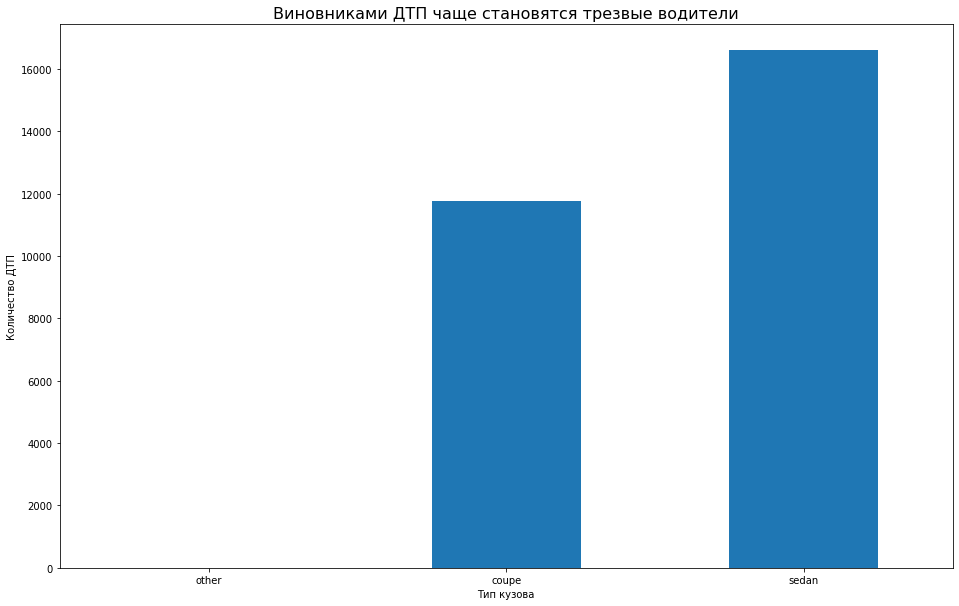

In [62]:
df_all_size = (                                                    # таблица зависимости at_fault от party_sobriety
    df_all
    .query('at_fault == 1')
    .groupby('vehicle_type')['at_fault']
    .count()
    .sort_values()
)
display(df_all_size.sort_values(ascending=False))                   # выводим таблицу зависимости at_fault от party_sobriety

fig = plt.figure(figsize=(16,10))
ax = df_all_size.plot.bar()
plt.title('Виновниками ДТП чаще становятся трезвые водители', fontsize=16)
plt.ylabel('Количество ДТП')
plt.xlabel('Тип кузова')
plt.xticks(rotation=0)
plt.show()

Виновниками ДТП чаще становятся водители автомобилей с типом кузова седан. Купе - семейный автомобиль, вероятно на нем водители часто ездят с родными или друзьями, что обязывает относиться к правилам дорожного движение серьезней.

**Вывод:**  
Наиболее важные признаки в деле прогнозирования риска ДТП:
 - vehicle_transmission (тип коробки передач);
 - vehicle_type (тип кузова);
 - party_sobriety (трезвость водителя);
 - control_device (устройство контроля);
 - vehicle_age (возраст автомобиля).
 
Виновниками ДТП чаще становятся водители автомобилей с механической коробкой передач.  
Виновниками ДТП чаще становятся водители автомобилей с типом кузова седан.  
Рекомендуется постепенный перевод автопарка на автомобили с типом кузова купе и автоматической коробкой передач.  

## Общий вывод
<a id="final"></a>

**Подключение к базе и загрузка таблицы данных**

В таблицах приведены данные по ДТП, по ним невозможно предсказать возможно ли избежать инцидента, так как данные по таковым исходам отсутствуют. Если до предоставленным данным предсказывать вероятность ДТП, то она составит 100%. Поскольку целевым признаком выбран at_fault (виновность участника), то результатом прогнозирования будет определение виновника ДТП. Это может быть полезно для контроля над финансовыми издержками, возникающими вследствие ДТП, но не для решения сформулированной в условиях задачи.  

1. таблица parties (описание участников происшествия):
 - в таблице 2752408 строк и 9 признаков. Признаки соответствуют указанным в условии;
 - полные дубликаты отсутствуют.
2. таблица collisions (информация о происшествиях):
 - в таблице 1400000 строк и 20 признаков. Признаки соответствуют указанным в условии;
 - полные дубликаты отсутствуют;
 - приведённый в условиях признак  control_condition_1 по факту имеет наименование control_device;
 - приведённый в условиях признак  primary_coll_factor по факту имеет наименование primary_collision_factor;
 - при импорте данных типы данных признаков collision_date и collision_time изменены с date и time на object.
3. таблица vehicles (Описание автомобиля):
 - в таблице 1021234 строк и 6 признаков. Признаки соответствуют указанным в условии;
 - полные дубликаты отсутствуют.
4. таблица case_ids:
 - в таблице 1400000 строк и 2 признаков. Признаки соответствуют указанным в условии;
 - полные дубликаты отсутствуют.
 
Таблицы связаны общим признаком case_id (уникальный номер для зарегистрированного происшествия).  
Таблицы vehicles и parties связаны признаком party_number (номер участника происшествия).  


**Статистический анализ факторов ДТП**

В таблицах содержатся данные по ДТП за период с января 2009 года по август 2020 года. Данных по событиям, произошедших после мая 2012 года, значительно меньше, нежели тех, что произошли до этой даты.  
Анализ выполнен на данных за период с июня 2009 по май 2012.  
Наименьшее количество аварий - в мае: 69173. Наибольшее количество аварий - осень: от 104517 в ноябре до 111933 в октябре.  

Для подготовки к совещанию предложено проработать следующие задачи:
1. Определить среднюю сумму страховки в зависимости возраста автомобиля (таблицы parties и vehicles).  
2. Определить количество нетрезвых виновников ДТП по дням недели (таблицы collisions и parties).  
3. Серьёзность происшествия в зависимости от освещения (таблица collisions).  
4. Определить количество участников ДТП в зависимости от погодных условий (таблица collisions).  
5. Определить дорожное состояние в зависимости удаленности от главной дороги (таблица collisions).  
6. Определить дорожное состояние в зависимости удаленности от географического района (таблица collisions).  

Приведены примеры решения первых двух задач. По ним можно сделать следующие выводы:  
1. Для автомобилей возрастом 0-4 года средняя сумма страховки колеблется в диапазоне 25-30 тысяч долларов.  
   Для автомобилей возрастом 4-14 лет средняя сумма страховки поступательно увеличивается до 78 тысяч долларов.  
   Для автомобилей возрастом свыше 14 лет средняя сумма страховки уменьшается: вероятно, возникают проблемы со страхованием столь старых автомобилей. Вероятно, часть автомобилей эксплуатируются без страховки.  
2. Количество ДТП по вине нетрезвых водителей - в будние дни, с понедельника по четверг. С пятницы количество ДТП по вине нетрезвых водителей возрастает и достигает пика в выходные дни.  


**Создание модели для оценки водительского риска**

1. Загруженные следующие признаки:
 - county_location;
 - distance;
 - direction;
 - intersection;
 - weather_1;
 - location_type;
 - motor_vehicle_involved_with;
 - road_surface;
 - road_condition_1;
 - lighting;
 - control_device;
 - collision_date;  
 - collision_time;  
 - vehicle_type;  
 - vehicle_transmission;  
 - vehicle_age;
 - party_sobriety;
 - at_fault.

2. В отдельные признаки выделены месяц, день и час события.  
3. Пропуски признаков intersection и vehicle_age заменены на наиболее часто встречающиеся значения.  
4. Пропуски признака "collision_hour" заменены на наиболее часто встречающиеся значение по дням недели.  
5. Пропуски текстовых признаков заменены на "not stated".  
6. Удалены события с аномальными значениями признаков distance и vehicle_age.
7. Корреляция (обратная) наблюдается только у признаков distance и intersection: -0.71.
8. Классы сбалансированы.  
9. Данные подготовлены для обучения моделей.


**Подбор лучшей модели**

Для решения поставленной задачи модель должна эффективно определять положительный класс: нужно выявить максимальное количество потенциальных виновников ДТП. При этом не имеет значения, будут ли ошибки в отношении клиентов, не представляющих угрозу. В связи с этим для оценки качества модели выбрана метрика Recall.  
Наилучший результат по данной метрике показала модель RandomForestClassifier. Скорость обучения модели - вторая среди рассматриваемых моделей.  
Метрики модели:  
 - recall: 0.612618;
 - F1: 0.621;
 - auc_roc: 0.621;
 - время обучения (секунд): 36.914706;
 - время предсказания (секунд): 0.089375;
  	 	 	 	
 
**Проверка лучшей модели**  

Наиболее важные признаки в деле прогнозирования риска ДТП:
 - vehicle_transmission (тип коробки передач);
 - vehicle_type (тип кузова);
 - party_sobriety (трезвость водителя);
 - control_device (устройство контроля);
 - vehicle_age (возраст автомобиля).
 
Виновниками ДТП чаще становятся водители автомобилей с механической коробкой передач.  
Виновниками ДТП чаще становятся водители автомобилей с типом кузова седан.  
Рекомендуется постепенный перевод автопарка на автомобили с типом кузова купе и автоматической коробкой передач.  